In [1]:
import nltk
from nltk.util import ngrams
import string
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
rcParams['figure.figsize'] = (12,9)
rcParams['figure.facecolor'] = '#d9cbd7'
from wordfreq import word_frequency
from tqdm import tqdm
import re
import random
random.seed = 42

In [2]:
def sort_dict(dictionary:dict):
    return dict(sorted(dictionary.items() , key=lambda x: dictionary.get(x[0]), reverse=True))

In [3]:

with open('guesses.csv', 'r') as f:
    words = f.read()
wordbank = words.split('\n')
wordbank = list(map(lambda word: word.upper(), wordbank))
selected =[]
with open('words.csv', 'r') as f:
    words = f.read()
selected = words.split('\n')
selected = list(map(lambda word: word.upper(), selected))

In [4]:
empty_letter_dict = {}
for letter in string.ascii_uppercase:
    empty_letter_dict[letter] = 0
letter_dict = copy(empty_letter_dict)
for word in wordbank:
    for letter in word:
        letter_dict[letter] += 1
letter_dict = sort_dict(letter_dict)

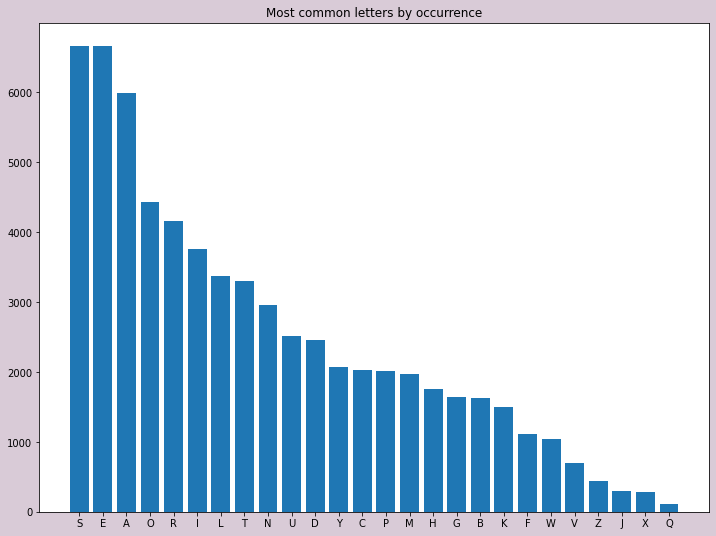

In [5]:
plt.bar(x=letter_dict.keys(), height=letter_dict.values())
plt.title('Most common letters by occurrence')
plt.show()

In [6]:
positions = {}
for i in range(5):
    positions[i] = {}
    for letter in string.ascii_uppercase:
        positions[i][letter] = 0
    

for word in wordbank:
    for i in range(5):
        letter = word[i]
        positions[i][letter] +=1
        positions[i] = sort_dict(positions[i])
    

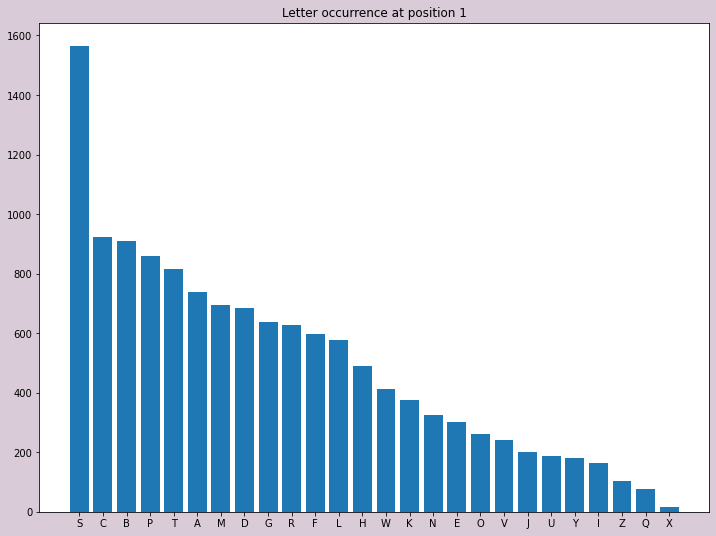

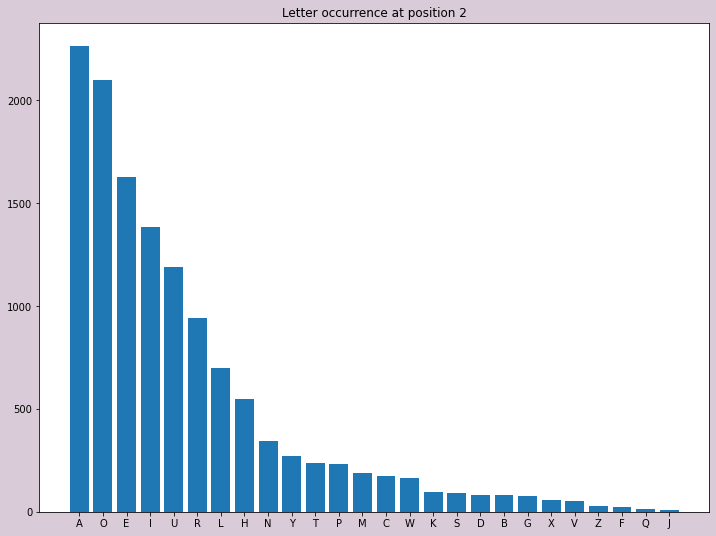

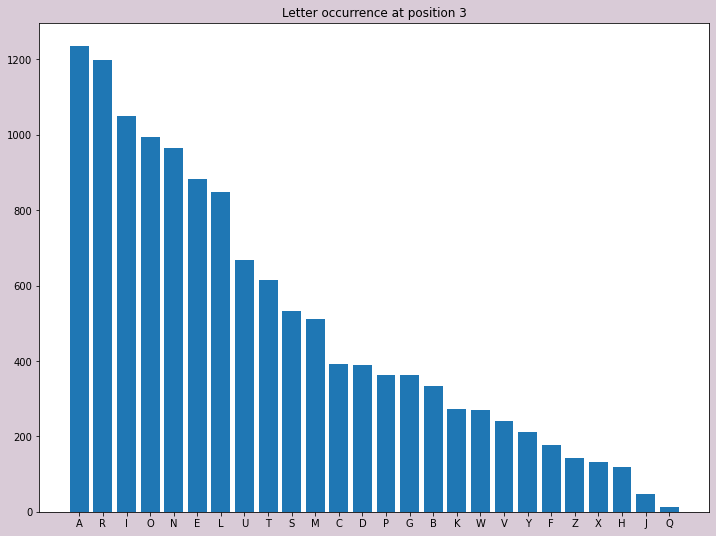

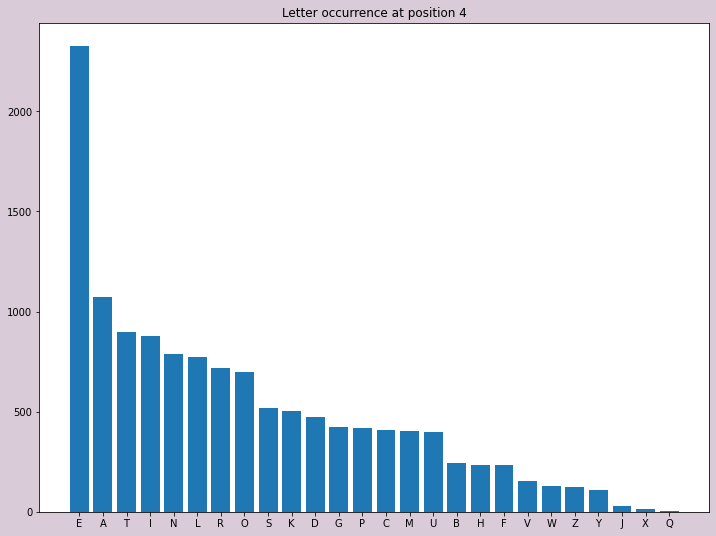

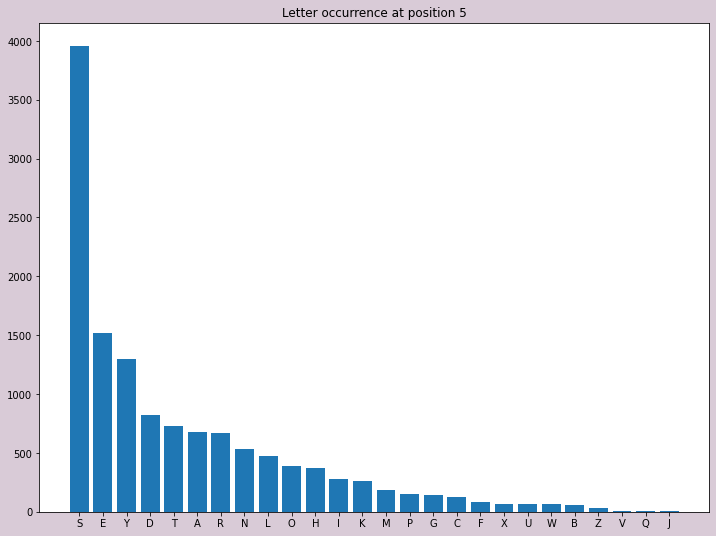

In [7]:
for i in range(5):
    plt.bar(x = positions[i].keys(), height = positions[i].values())
    plt.title(f'Letter occurrence at position {i+1}')
    plt.show()

In [8]:
rev_occurence = {}
for letter in string.ascii_uppercase:
    rev_occurence[letter] = {}
    total = letter_dict[letter]
    for i in range(5):
        rev_occurence[letter][i] = positions[i][letter]
        

In [9]:
labels = list(range(5))

def absolute_vals(values):
    def abs_val(pct):
        total = sum(values)
        absolute = round(pct * total/100)
        return f'{absolute} ({pct:.2f} %)'
    return abs_val


for letter in string.ascii_uppercase:
    fig, axs = plt.subplots()
    plt.pie(rev_occurence[letter].values(), labels= [1,2,3,4,5], autopct= absolute_vals(rev_occurence[letter].values()),
    startangle=90, counterclock=False)
    centre_circle = plt.Circle((0,0),0.8,fc='#d9cbd7')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title(f'Distribution of positions for letter {letter}')
    plt.savefig(f'donuts/{letter}.jpg')
    plt.close()

In [10]:
rep_1, rep_2, rep_3 = 0,0,0
for word in wordbank:
    if len(list(word)) - len(set(word)) == 1:
        rep_1 +=1
    elif len(list(word)) - len(set(word)) == 2:
        rep_2 +=1
    elif len(list(word)) - len(set(word)) == 3:
        rep_3 +=1


In [11]:
n = 2
bigram_dict = {}
for word in wordbank:
    bigrams = list(ngrams(word, n))
    for bigram in bigrams:
        if bigram not in bigram_dict:
            bigram_dict[bigram] = 1
        else:
            bigram_dict[bigram]+= 1

In [12]:
bigram_dict = sort_dict(bigram_dict)
filtered_bg = {k:v for k,v in bigram_dict.items() if v >=20 }
filtered_bg = dict(list(filtered_bg.items()))
keys = list(''.join(key) for key in filtered_bg.keys())
bg_dict = dict(zip(keys, filtered_bg.values()))

In [17]:
def get_diff(guess, answer):
    ans_grid=[0]*5
    guess = list(guess.upper())
    answer = list(answer.upper())
    idx = 0
    while len(guess) > 0:
        letter = guess.pop(0)
        if letter in answer:
            if answer.index(letter) == idx:
                ans_grid[idx] = 10
            else:
                ans_grid[idx] = 5
            answer[answer.index(letter)] = 0
        idx += 1
    return ans_grid

In [18]:
grid1 = get_diff('mimic', 'mince')

In [19]:
def get_regex(guess, ans_grid):
    guess = guess.upper()
    discarded = []
    misplaced = []
    build = ''
    for i in range(5):
        if ans_grid[i] == 0:
            discarded.append(guess[i])
    for i in range(5):
        if ans_grid[i] == 10:
            build += guess[i]
        elif ans_grid[i] == 5:
            misplaced.append(guess[i])
            build += f'[^{guess[i]}{"".join(discarded)}]'
        else:
            build+= f'[^{"".join(discarded)}]'
    return build, misplaced

In [20]:
restring = get_regex('mimic', grid1)

In [21]:
restring

('MI[^MI][^MI][^CMI]', ['C'])

In [81]:
def get_possible_words(guess, ans_grid, wordbank=wordbank):
    possibilities = []
    restring, misplaced = get_regex(guess, ans_grid)
    for word in wordbank:
        if re.match(restring, word):
            possibilities.append(word)
    filtered = []
    for letter in misplaced:
        for word in possibilities:
            if letter not in word:
                filtered.append(word)
    for word in set(filtered):
        possibilities.remove(word)
    possibilities = sorted(possibilities, key=lambda x: word_frequency(x, 'en'), reverse=True)
    return possibilities